In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

In [2]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index('date', inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse

In [4]:
del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# Autoregressive Model (AR)

A linear model where current period values are a sum of past outcomes multiplied by a numeric factor

Xt = C + phi * Xt-1 + Et

Xt-1 The values of X during the previous period

phi Any numberic constant by which we multiply the lagged variable (has to be between -1 and 1)

Et Residual - The difference between our prediction for period 't' and the correct value

More lags > More complicated > More coefficients > More likely NOT significant

### Using ACF and PACF to determine the appropriate number of lags

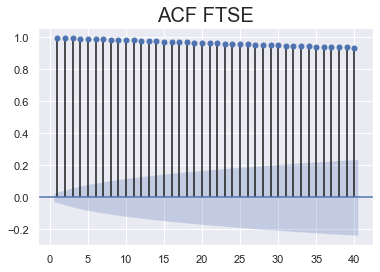

In [5]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title('ACF FTSE', size=20)
plt.show()

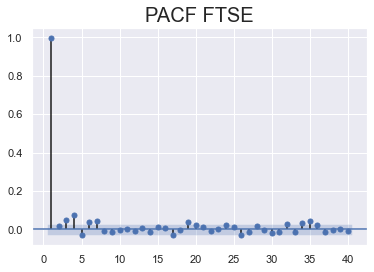

In [6]:
sgt.plot_pacf(df.market_value, lags=40, zero=False, method=('ols'))
plt.title('PACF FTSE', size=20)
plt.show()

### Fitting an AR(1) Model for FTSE Index prices

We are using PACF because it shows the individual effect each past value has on the current one

In [7]:
model_ar = ARMA(df.market_value, order=(1, 0)) # order=(1, 0) is a simple AR model

In [8]:
results_ar = model_ar.fit() # fitting the model - finding the most appropriate coefficients

In [9]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.598
Method:                       css-mle   S.D. of innovations             59.258
Date:                Thu, 21 Oct 2021   AIC                          55251.195
Time:                        21:50:26   BIC                          55270.759
Sample:                    01-07-1994   HQIC                         55258.051
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5031.8523    487.610     10.319      0.000    4076.154    5987.551
ar.L1.market_value     0.9985      0.001   1298.321      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

### Fitting higher-lag AR models for FTSE prices

In [10]:
model_ar2 = ARMA(df.market_value, order=(2, 0))
results_ar2 = model_ar2.fit()
results_ar2.summary()

# ar2 coefficients are almost 0, so we can assume values from 2 days ago don't influence values from today directly

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.868
Method:                       css-mle   S.D. of innovations             59.249
Date:                Thu, 21 Oct 2021   AIC                          55251.737
Time:                        21:50:27   BIC                          55277.822
Sample:                    01-07-1994   HQIC                         55260.877
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5070.5735    487.501     10.401      0.000    4115.088    6026.058
ar.L1.market_value     0.9816      0.014     69.602      0.000       0.954       1.009
ar.L2.market_value     0.0169      0.014      1.198      0.231      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -59.0593           +0.0000j           59.0593            0.5000
-----------------------------------------------------------------------------
"""

In [11]:
model_ar3 = ARMA(df.market_value, order=(3, 0))
results_ar3 = model_ar3.fit()
results_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.871
Method:                       css-mle   S.D. of innovations             59.178
Date:                Thu, 21 Oct 2021   AIC                          55241.742
Time:                        21:50:28   BIC                          55274.349
Sample:                    01-07-1994   HQIC                         55253.168
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    520.352      9.781      0.000    4069.770    6109.512
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value    -0.0309      0.020     -1.563      0.118      -0.070       0.008
ar.L3.market_value     0.0489      0.014      3.466      0.001       0.021       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.1850           -4.5161j            4.5199           -0.2565
AR.3           -0.1850           +4.5161j            4.5199            0.2565
-----------------------------------------------------------------------------
"""

### LLR - Log-Likelihood test

In [12]:
def LLR_test(mod_1, mod_2, DF=1): # models we want to compare and degrees of freedom
  L1 = mod_1.fit().llf
  L2 = mod_2.fit().llf
  LR = (2 * (L2 - L1))
  p = chi2.sf(LR, DF).round(3)
  return p


In [13]:
LLR_test(model_ar2, model_ar3)

0.001

In [14]:
model_ar4 = ARMA(df.market_value, order=[4, 0])
results_ar4 = model_ar4.fit()
print(results_ar4.summary())
print("\nLLR test p-value", str(LLR_test(model_ar3, model_ar4)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Thu, 21 Oct 2021   AIC                          55217.130
Time:                        21:50:29   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    559.967      9.089      0.000    3992.125    6187.157
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value  

In [15]:
model_ar5 = ARMA(df.market_value, order=[5, 0])
results_ar5 = model_ar5.fit()
print(results_ar5.summary())
print("\nLLR test p-value", str(LLR_test(model_ar4, model_ar5)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 0)   Log Likelihood              -27600.348
Method:                       css-mle   S.D. of innovations             58.996
Date:                Thu, 21 Oct 2021   AIC                          55214.697
Time:                        21:50:31   BIC                          55260.346
Sample:                    01-07-1994   HQIC                         55230.693
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6414    543.564      9.363      0.000    4024.275    6155.008
ar.L1.market_value     0.9791      0.014     69.481      0.000       0.952       1.007
ar.L2.market_value  

In [16]:
model_ar6 = ARMA(df.market_value, order=[6, 0])
results_ar6 = model_ar6.fit()
print(results_ar6.summary())
print("\nLLR test p-value", str(LLR_test(model_ar5, model_ar6)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 0)   Log Likelihood              -27596.474
Method:                       css-mle   S.D. of innovations             58.950
Date:                Thu, 21 Oct 2021   AIC                          55208.947
Time:                        21:50:33   BIC                          55261.118
Sample:                    01-07-1994   HQIC                         55227.229
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    565.229      9.005      0.000    3981.813    6197.469
ar.L1.market_value     0.9803      0.014     69.604      0.000       0.953       1.008
ar.L2.market_value  

In [17]:
model_ar7 = ARMA(df.market_value, order=[7, 0])
results_ar7 = model_ar7.fit()
print(results_ar7.summary())
print("\nLLR test p-value", str(LLR_test(model_ar6, model_ar7)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 0)   Log Likelihood              -27591.900
Method:                       css-mle   S.D. of innovations             58.896
Date:                Thu, 21 Oct 2021   AIC                          55201.799
Time:                        21:50:37   BIC                          55260.492
Sample:                    01-07-1994   HQIC                         55222.366
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6414    589.583      8.633      0.000    3934.080    6245.202
ar.L1.market_value     0.9786      0.014     69.518      0.000       0.951       1.006
ar.L2.market_value  

In [18]:
model_ar8 = ARMA(df.market_value, order=[8, 0])
results_ar8 = model_ar8.fit()
print(results_ar8.summary())
print("\nLLR test p-value", str(LLR_test(model_ar7, model_ar8)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -27591.739
Method:                       css-mle   S.D. of innovations             58.894
Date:                Thu, 21 Oct 2021   AIC                          55203.478
Time:                        21:50:41   BIC                          55268.692
Sample:                    01-07-1994   HQIC                         55226.329
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6415    584.989      8.700      0.000    3943.083    6236.200
ar.L1.market_value     0.9790      0.014     69.476      0.000       0.951       1.007
ar.L2.market_value  

In [19]:
print('LLR test: ' + str(LLR_test(model_ar, model_ar7, DF=6)))

# We choose AR(7) because AR(8) fails the LLR test, does not provide significatly higher Log-Likelihood and has higher information criteria

LLR test: 0.0


AR(N+1) > AR(N)

### Using returns

Express percentage change between the values for two consecutive periods

Positive r>0 indicates price raise, while negative r<0 indicates price decrease

In [23]:
# DF test
sts.adfuller(df.market_value)

(-1.90415514188369,
 0.3301089327702815,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

In [24]:
# Create return out of prices
# Use 1 period distance, and multiply by 100 to get percentage
df['returns'] = df.market_value.pct_change(1).mul(100) 
df = df.iloc[1:]

<ipython-input-24-626651c91034>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value.pct_change(1).mul(100)


In [25]:
sts.adfuller(df.returns) # second value is zero which means it's a stationary generated data

(-12.77026571949722,
 7.798058336038942e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

## ACF and PACF for returns

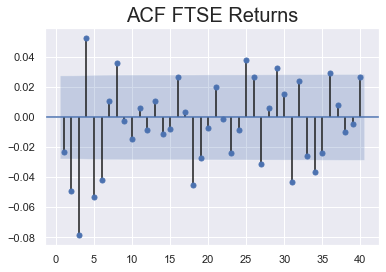

In [26]:
sgt.plot_acf(df.returns, lags=40, zero=False)
plt.title('ACF FTSE Returns', size=20)
plt.show()

# acf shows consecutive values move in different directions which means some form of natural adjustment occuring in the market

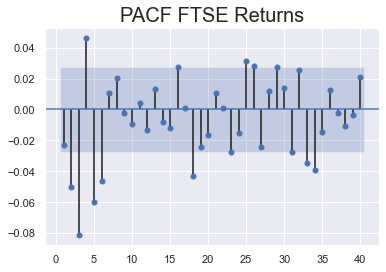

In [28]:
sgt.plot_pacf(df.returns, lags=40, zero=False, method=('ols'))
plt.title('PACF FTSE Returns', size=20)
plt.show()

# similar results as acf
# 5 of the first 6 coefficients are negative, so there is evidence of clustering